# Stability and Speedup in PyTorch

The techniques we will cover in this chapter are not going to be extremely useful to MNIST with a fully connected neural network. But all those techniques are going to be essential in the chapters to come. In this chapter we will only focus on the implementation. The full potential of their usefulness will most likely only become apparent once we start to implement more complex neural network architectures.

We start with implementing our usual overhead procedures. We import the necessary libraries, create datasets and dataloaders and implement functions that are useful for training and performance tracking. 

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
train_validation_dataset = MNIST(root="../datasets/", train=True, download=True, transform=T.ToTensor())
test_dataset = MNIST(root="../datasets", train=False, download=False, transform=T.ToTensor())

In [3]:
stratify = train_validation_dataset.targets.numpy()
train_idxs, val_idxs = train_test_split(
                                range(len(train_validation_dataset)),
                                stratify=stratify,
                                test_size=0.1)

In [4]:
train_dataset = Subset(train_validation_dataset, train_idxs)
val_dataset = Subset(train_validation_dataset, val_idxs)

In [5]:
# parameters
DEVICE = ("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS=30
BATCH_SIZE=128
HIDDEN_SIZE_1 = 100
HIDDEN_SIZE_2 = 50
NUM_LABELS = 10
NUM_FEATURES = 28*28
ALPHA=0.001

In [6]:
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True,
                              num_workers=4)

val_dataloader = DataLoader(dataset=val_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              drop_last=False,
                              num_workers=4)

test_dataloader = DataLoader(dataset=test_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              drop_last=False,
                              num_workers=4)

In [7]:
def track_performance(dataloader, model, criterion):
    # switch to evaluation mode
    model.eval()
    num_samples = 0
    num_correct = 0
    loss_sum = 0
    
    # no need to calculate gradients
    with torch.inference_mode():
        for batch_idx, (features, labels) in enumerate(dataloader):
            features = features.view(-1, NUM_FEATURES).to(DEVICE)
            labels = labels.to(DEVICE)
            logits = model(features)
            
            predictions = logits.max(dim=1)[1]
            num_correct += (predictions == labels).sum().item()
            
            loss = criterion(logits, labels)
            loss_sum += loss.cpu().item()
            num_samples += len(features)
    
    # we return the average loss and the accuracy
    return loss_sum/num_samples, num_correct/num_samples

In [8]:
def train(train_dataloader, val_dataloader, model, criterion, optimizer):
    # track progress over time
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    for epoch in range(NUM_EPOCHS):
        loss_sum = 0
        batch_nums = 0
        for batch_idx, (features, labels) in enumerate(train_dataloader):
            # switch to training mode
            model.train()
            # move features and labels to GPU
            features = features.view(-1, NUM_FEATURES).to(DEVICE)
            labels = labels.to(DEVICE)

            # ------ FORWARD PASS --------
            probs = model(features)

            # ------CALCULATE LOSS --------
            loss = criterion(probs, labels)

            # ------BACKPROPAGATION --------
            loss.backward()

            # ------GRADIENT DESCENT --------
            optimizer.step()

            # ------CLEAR GRADIENTS --------
            optimizer.zero_grad()

        # ------TRACK LOSS --------
        train_loss, train_acc = track_performance(train_dataloader, model, criterion)
        val_loss, val_acc = track_performance(val_dataloader, model, criterion)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Val Loss: {val_loss}')
    return history

In [9]:
def plot_history(history):
    fig = plt.figure(figsize=(12, 5))

    fig.add_subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Cross-Entropy")
    plt.legend()
    
    fig.add_subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(NUM_FEATURES, HIDDEN_SIZE_1),
                nn.ReLU(),
                nn.Linear(HIDDEN_SIZE_1, HIDDEN_SIZE_2),
                nn.ReLU(),
                nn.Linear(HIDDEN_SIZE_2, NUM_LABELS),
            )
    
    def forward(self, features):
        return self.layers(features)

## Optimizers

To use a different optimizer in PyTorch is a one liner in PyTorch.

Stochastic gradient descent with momentum for example requires you to pass an additional momentum argument.

In [11]:
model = Model().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=ALPHA, momentum=0.9)

RMSProp is a separate optimer `optim.RMSprop(params, lr=0.01, alpha=0.99)`. The `alpha` paramter is the smoothing constant (we used $\beta_2$ in our theoretical discussion). For the most part you can probably leave initial values.

In [12]:
optimizer = optim.RMSprop(model.parameters(), lr=ALPHA)

Here we are utilizing Adam with the initial values, `optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)`.

In [13]:
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=ALPHA)

In [14]:
history = train(train_dataloader, val_dataloader, model, criterion, optimizer)

Epoch: 1/30 | Train Loss: 0.23290906087307353 | Val Loss: 0.24752659384409587
Epoch: 10/30 | Train Loss: 0.03445472979957941 | Val Loss: 0.0890826229651769
Epoch: 20/30 | Train Loss: 0.011194809274819863 | Val Loss: 0.11647629233201345
Epoch: 30/30 | Train Loss: 0.005233177990947669 | Val Loss: 0.13508533628781635


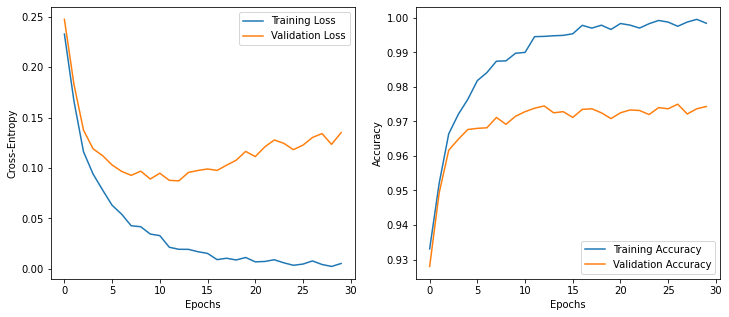

In [15]:
plot_history(history)

## Batch Normalization

According to the authors of batch normalization, this technique makes you model less sensitive to bat initial weights and allows you to train much deeper models. So let's test that out. In a previous section we showed that a neural network with more than 5 layers that uses the sigmoid activation function will suffer from vanishing gradients. We also showed that we can change initial weights to battle the problem. This time around we will keep the initial weight initialization scheme and introduce even more layers. And still the network will train.

For that purpose we will introduce a module that we will reuse over and over again. The `BatchModule` is just a succession of a linear layer, batch normalization and the sigmoid activation function. Notice that we use `BatchNorm1d`. The `1d` implies that we are dealing with a flattened vector and not with an actual image (for example 1x28x28). There is obviously also a `BatchNorm2d` for images.

In [16]:
HIDDEN = 70

In [17]:
class BatchModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(HIDDEN, HIDDEN),
            nn.BatchNorm1d(HIDDEN),
            nn.Sigmoid()
        )
    
    def forward(self, features):
        return self.layers(features)

We reuse the module 10 times.

In [18]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(NUM_FEATURES, HIDDEN),
                BatchModule(),
                BatchModule(),
                BatchModule(),
                BatchModule(),
                BatchModule(),
                BatchModule(),
                BatchModule(),
                BatchModule(),
                BatchModule(),
                BatchModule(),
                nn.Linear(HIDDEN, NUM_LABELS),
            )
    
    def forward(self, features):
        return self.layers(features)

In [19]:
model = Model().to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=ALPHA)

BatchNorm can deal with the vanishing gradient problem.

In [20]:
history = train(train_dataloader, val_dataloader, model, criterion, optimizer)

Epoch: 1/30 | Train Loss: 0.29193277126111783 | Val Loss: 0.309956553141276
Epoch: 10/30 | Train Loss: 0.052912827264827246 | Val Loss: 0.09414926405747731
Epoch: 20/30 | Train Loss: 0.03870163636277662 | Val Loss: 0.10704288717110952
Epoch: 30/30 | Train Loss: 0.027636287571871188 | Val Loss: 0.10638620771964391


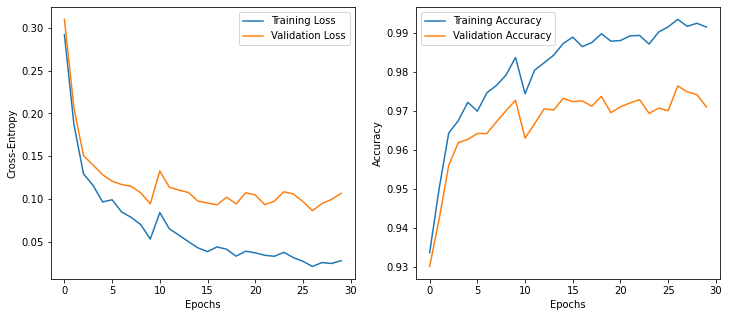

In [21]:
plot_history(history)

## Skip Connections

Below we are going to do a similar exercise with skip connections that we did with batch normalization. 

In [22]:
HIDDEN = 70

We first introduce a separate `ResNet` block. The block takes some hidden features as input processes the input through a linear layer and a ReLU activation function and adds the processed value to the original input.

In [23]:
class ResBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(HIDDEN, HIDDEN)
        
        
    def forward(self, features):
        output = F.relu(self.linear(features))
        return features + output

We reuse that block 20 times.

In [24]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(NUM_FEATURES, HIDDEN),
                nn.ReLU(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                ResBlock(),
                nn.Linear(HIDDEN, NUM_LABELS),
            )
    
    def forward(self, features):
        return self.layers(features)

In [25]:
model = Model().to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=ALPHA)

Even with such a deep neural network we do not encounter vanishing gradients. 

In [26]:
history = train(train_dataloader, val_dataloader, model, criterion, optimizer)

Epoch: 1/30 | Train Loss: 0.2665100422402459 | Val Loss: 0.28800799083709716
Epoch: 10/30 | Train Loss: 0.08378618202147886 | Val Loss: 0.14411730523904165
Epoch: 20/30 | Train Loss: 0.04129855185492747 | Val Loss: 0.11496934262911479
Epoch: 30/30 | Train Loss: 0.0302913933677152 | Val Loss: 0.13047391112645468


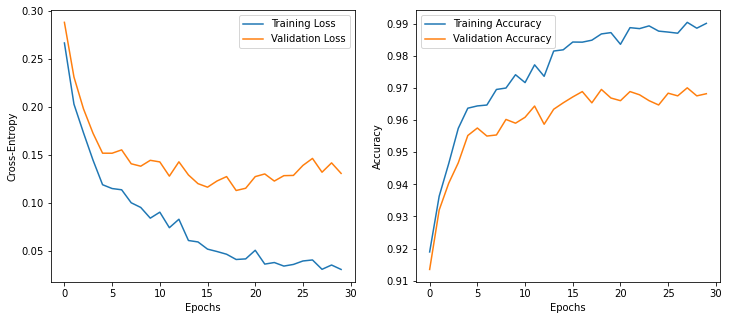

In [27]:
plot_history(history)

## Learning Rate Scheduling

We will return to our simple model to only focus on learning rate decay.

In [28]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(NUM_FEATURES, HIDDEN_SIZE_1),
                nn.ReLU(),
                nn.Linear(HIDDEN_SIZE_1, HIDDEN_SIZE_2),
                nn.ReLU(),
                nn.Linear(HIDDEN_SIZE_2, NUM_LABELS),
            )
    
    def forward(self, features):
        return self.layers(features)

Schedulers in PyTorch are located in `otpim.lr_scheduler`, in our example we pick `optim.schedulers.ReduceLROnPlateau`. All schedulers take an optimizer as input. This is necessary because the learning rate is basically a part of an optimizer and the scheduler has to modify a paramter of that optimizer. The `patience=2` is a `ReduceLROnPlateau` specific paramter that inidicates how many epochs the performance metric (like cross-entropy) has to shrink in order to for the learning rate to be multiplied by the factor of 0.1.

In [29]:
model = Model().to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1)

We have to adjust the train function to introduce the scheduler logic. Similar to the `optimizer.step` function there is a `scheduler.step` function. This function takes a performance measure at the end of an epoch, in our case we provide the validation loss as the performance measure `scheduler.step(val_loss)`.

We additionally would like to track the development of the learning rate. Each optimizer in PyTorch has a `state_dict()` method, that returns the state of the optimizer. The function returns a dictionary with two keys: `state` and `param_groups`. The `state` can for example contain the moving averages for the momentum calculations. The `param_groups` contain the parameters that are necessary for gradient descent. Let's see what it looks like for Adam.

In [30]:
optimizer.state_dict()['param_groups']

[{'lr': 0.01,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'params': [0, 1, 2, 3, 4, 5]}]

So in order to get the learning rate we have to make the following call.

In [31]:
optimizer.state_dict()['param_groups'][0]['lr']

0.01

In [32]:
def train(train_dataloader, val_dataloader, model, criterion, optimizer, scheduler):
    # track progress over time
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    for epoch in range(NUM_EPOCHS):
        loss_sum = 0
        batch_nums = 0
        for batch_idx, (features, labels) in enumerate(train_dataloader):
            # switch to training mode
            model.train()
            # move features and labels to GPU
            features = features.view(-1, NUM_FEATURES).to(DEVICE)
            labels = labels.to(DEVICE)

            # ------ FORWARD PASS --------
            probs = model(features)

            # ------CALCULATE LOSS --------
            loss = criterion(probs, labels)

            # ------BACKPROPAGATION --------
            loss.backward()

            # ------GRADIENT DESCENT --------
            optimizer.step()

            # ------CLEAR GRADIENTS --------
            optimizer.zero_grad()

        
        # ------TRACK LOSS --------
        train_loss, train_acc = track_performance(train_dataloader, model, criterion)
        val_loss, val_acc = track_performance(val_dataloader, model, criterion)
        
        # ------ADJUST LEARNING RATE --------
        scheduler.step(val_loss)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        
        learning_rate = optimizer.state_dict()['param_groups'][0]['lr']
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Val Loss: {val_loss} | Learning Rate: {learning_rate:.6f}')
    return history

Because the model overfits extremely fast, the learning rate gets very close to 0 very fast.

In [33]:
history = train(train_dataloader, val_dataloader, model, criterion, optimizer, scheduler)

Epoch: 1/30 | Train Loss: 0.15108584009128626 | Val Loss: 0.18331660691897075 | Learning Rate: 0.010000
Epoch: 10/30 | Train Loss: 0.009933812922168736 | Val Loss: 0.08812547284861405 | Learning Rate: 0.001000
Epoch: 20/30 | Train Loss: 0.006792926298321121 | Val Loss: 0.0915812975987792 | Learning Rate: 0.000000
Epoch: 30/30 | Train Loss: 0.0067768237371413275 | Val Loss: 0.09158582832415899 | Learning Rate: 0.000000


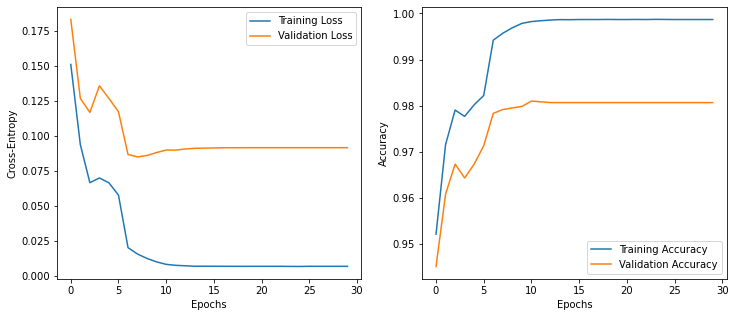

In [34]:
plot_history(history)